### Data -- Wait time stats actual view

In [5]:
# pip install psycopg2
#!pip install snowflake
#!pip install lightgbm
#!pip install gtfs-realtime-bindings

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import psycopg2
from datetime import datetime
import requests
from datetime import date
from datetime import timedelta
import snowflake.connector

In [38]:
# Connect to Snowflake
conn = snowflake.connector.connect(
    user='SPARK',
    authenticator = "externalbrowser",
    account='BROOKLYNSPORTSANDENTERTAINMENT-BSEGLOBAL',  # e.g., xy12345.us-east-1
    warehouse='All Too Ware',
    database='BSEDW',
    schema='WAITTIME', 
    role = "SNOWFLAKE_DOMINATEAI"
)
cursor = conn.cursor()
# Explicitly activate the warehouse
cursor.execute('USE WAREHOUSE "All Too Ware"')

# Query data
query = "SELECT * FROM WAITTIME_STATSACTUALVIEW where EVENT_DATE <= '2025-07-27'"
cursor.execute(query)

# Convert to pandas DataFrame
df = cursor.fetch_pandas_all()

# Close the connection
cursor.close()
conn.close()

# Display results
print(df.head())


Initiating login request with your identity provider. A browser window should have opened for you to complete the login. If you can't see it, check existing browser windows, or your OS settings. Press CTRL+C to abort and try again...
Going to open: https://bseglobal.okta.com/app/snowflake/exkqh96ogn06lUM3g4x7/sso/saml?SAMLRequest=rZNRc%2BIgFIX%2FSoZ9TsDousqoHVtHmx3btTX2oW%2BYYGRCIHKJif9%2BMVan%2B9A%2B7RsD59z7cQ%2BM7ppCekduQGg1Rp2AII%2BrRKdCZWO0ief%2BAHlgmUqZ1IqP0YkDupuMgBWypNPK7tUrP1QcrOcKKaDtwRhVRlHNQABVrOBAbULX06clDQNCS6OtTrREnyzfOxgAN9YRXi0pCIe3t7akGNd1HdTdQJsMh4QQTIbYqc6SH1d94%2B70hb6DSe%2BsdwonX32w3Qt1GcF3WNuLCOhjHK%2F81Z91jLzpFfVBK6gKbtbcHEXCN6%2FLCwA4gq3ROpcnBaU2FtxwubLOxYQq3MrfAs%2Bk3jIZgNL1TrKcJ7ooK%2BuaBW6FdzzFUmfCzSOajVGZizTn80W8jZ%2Ft6uUQzfP942KxjjdZckyTqjHL3VvZrMPf9a55iRLkvV0DD8%2BBRwAVj9Q5Zuu2SPjTJwOf9OKQ0F6fdgdBtzN8R97MxSwUs63zdpcbrM4ta%2FFYWeIbOeZNftgP%2BzpTpC83T92s1%2FzCABqfc0eXp0RbBDP5TwMa4c9FPx7rs8svmq20FMnJm2tTMPt1vJ2g0%2B6I1N%2B1UsoLJuQ0TQ0HcDFLqesHw5l1f8KaiiM8uXT9

In [40]:
# Convert all column names to lowercase
df.columns = df.columns.str.lower()

In [ ]:
needed_columns = ['event_name',
'event_name_long',
'season_name',
'season_year',
'event_date',
'event_time',
'event_day',
'starttime',
'team',
'minor_category',
'property',
'numberinline',
'relative start (minutes)',
'wait time (minutes)',
'time category']

df = df[needed_columns]

In [42]:
# CSV
df.to_csv('wait time.csv', index=False)  

In [43]:
# Convert times 
df['event_date'] = pd.to_datetime(df['event_date'])
df['starttime'] = pd.to_datetime(df['starttime'], errors='coerce')
df['event_time'] = pd.to_datetime(df['event_time'], format='%H:%M:%S').dt.time

# Note: relative start (minutes) should already be calculated in the source data
# If it's missing, we would need the actual timestamp column to compute it

C:\Users\spark\AppData\Local\Temp\ipykernel_9196\3570812377.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['event_date'] = pd.to_datetime(df['event_date'])
C:\Users\spark\AppData\Local\Temp\ipykernel_9196\3570812377.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['starttime'] = pd.to_datetime(df['starttime'], errors='coerce')
C:\Users\spark\AppData\Local\Temp\ipykernel_9196\3570812377.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

In [44]:
# Remove upsell or irrelevant events
df = df[~(df['event_name_long'].str.contains("Upsell", na=False) | 
          df['event_name_long'].str.contains("CANCELED", na=False) |
          df['event_name_long'].str.contains("Cancelled", na=False) |
          df['event_name_long'].str.contains("Libs for Kids 2023 Holding Event", na=False) |
          df['event_name_long'].str.contains("Test", na=False) |
          df['team'].str.contains("Test", case=False, na=False))]

# Drop nulls in critical columns
df = df.dropna(subset=['relative start (minutes)', 'wait time (minutes)', 'numberinline'])

In [45]:
# Verify that test - brooklyn nets rows are removed
test_rows = df[df['team'].str.contains("test", case=False, na=False)]
print(f"Rows with 'test' in team name after filtering: {len(test_rows)}")
if len(test_rows) > 0:
    print("Teams still containing 'test':")
    print(test_rows['team'].value_counts())
else:
    print("✓ Successfully removed all rows with 'test' in team name")

Rows with 'test' in team name after filtering: 0
✓ Successfully removed all rows with 'test' in team name


### Relative start time cutoffs

In [46]:
# Print minimum and maximum event_date
print('Minimum event_date:', df['event_date'].min())
print('Maximum event_date:', df['event_date'].max())

Minimum event_date: 2023-09-01 00:00:00
Maximum event_date: 2025-07-26 00:00:00


In [47]:
# Round to nearest minute
df['relative start (minutes)'].astype(int) 

# Filter out after-event tail if not useful
df = df[df['relative start (minutes)'] <= 30] # Operataional cutoff 
df = df[df['relative start (minutes)'] >= -100]

### Per Property

In [48]:
df.groupby('property').agg({
    'event_name': ['count', 'nunique']  # total events and unique events
}).round()


event_name        
                   count nunique
property                        
Barclays          123519     195
Brooklyn Nets      65034      80
Liberty            21249      38

In [49]:
df_barclays = df[df['property'] == 'Barclays']

In [50]:
df_barclays.describe()

,event_date,starttime,numberinline,relative start (minutes),wait time (minutes)
count,123519,123519,123519.000000,123519.000000,123519.000000
mean,2024-05-02 21:03:50.743448064,2024-05-03 12:20:21.086164992,56.541876,-26.920037,5.101936
min,2023-09-22 00:00:00,2023-09-22 18:00:01,1.000000,-100.000000,0.060000
25%,2023-12-31 00:00:00,2023-12-31 19:00:02,4.000000,-55.000000,1.000000
50%,2024-03-28 00:00:00,2024-03-28 17:00:03,15.000000,-25.000000,3.000000
75%,2024-09-07 00:00:00,2024-09-07 18:00:02,99.000000,2.000000,8.310000
max,2025-07-18 00:00:00,2025-07-18 16:43:50,439.000000,30.000000,31.460000
std,NaN,NaN,75.095117,34.347287,5.173776


In [51]:
df_liberty = df[df['property'] == 'Liberty']

In [52]:
df_liberty.describe()

,event_date,starttime,numberinline,relative start (minutes),wait time (minutes)
count,21249,21249,21249.000000,21249.000000,21249.000000
mean,2024-07-29 05:07:15.578145024,2024-07-29 15:45:06.984611072,78.385901,-27.583886,6.226118
min,2023-09-01 00:00:00,2023-09-01 18:00:03,1.000000,-100.000000,0.060000
25%,2024-05-31 00:00:00,2024-05-31 17:30:03,7.000000,-56.000000,1.000000
50%,2024-07-02 00:00:00,2024-07-02 17:02:10,23.000000,-23.000000,3.230000
75%,2024-09-08 00:00:00,2024-09-08 14:00:02,145.000000,1.000000,10.390000
max,2025-07-26 00:00:00,2025-07-26 17:00:05,423.000000,30.000000,30.320000
std,NaN,NaN,96.203799,34.574727,6.636195


In [53]:
df_nets = df[df['property'] == 'Brooklyn Nets']

In [54]:
df_nets.describe()

,event_date,starttime,numberinline,relative start (minutes),wait time (minutes)
count,65034,65034,65034.000000,65034.000000,65034.000000
mean,2024-03-23 07:18:28.995294720,2024-03-24 00:02:10.154488064,72.083649,-33.163914,6.111026
min,2023-10-12 00:00:00,2023-10-12 17:30:02,1.000000,-100.000000,0.060000
25%,2023-12-02 00:00:00,2023-12-02 17:00:02,3.000000,-63.000000,1.000000
50%,2024-02-05 00:00:00,2024-02-05 17:30:02,16.000000,-31.000000,3.580000
75%,2024-04-06 00:00:00,2024-04-06 17:00:04,141.000000,-3.000000,10.390000
max,2025-04-13 00:00:00,2025-04-13 11:00:00,423.000000,30.000000,30.320000
std,NaN,NaN,88.496853,36.159482,5.960482


In [55]:
df_barclays = df_barclays.drop('property', axis=1)
df_liberty = df_liberty.drop('property', axis=1)
df_nets = df_nets.drop('property', axis=1)

### Wait Time Distribution by Relative Start Time and Property

C:\Users\spark\AppData\Local\Temp\ipykernel_9196\1694339793.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = ax2.boxplot(box_data, labels=box_labels, patch_artist=True)


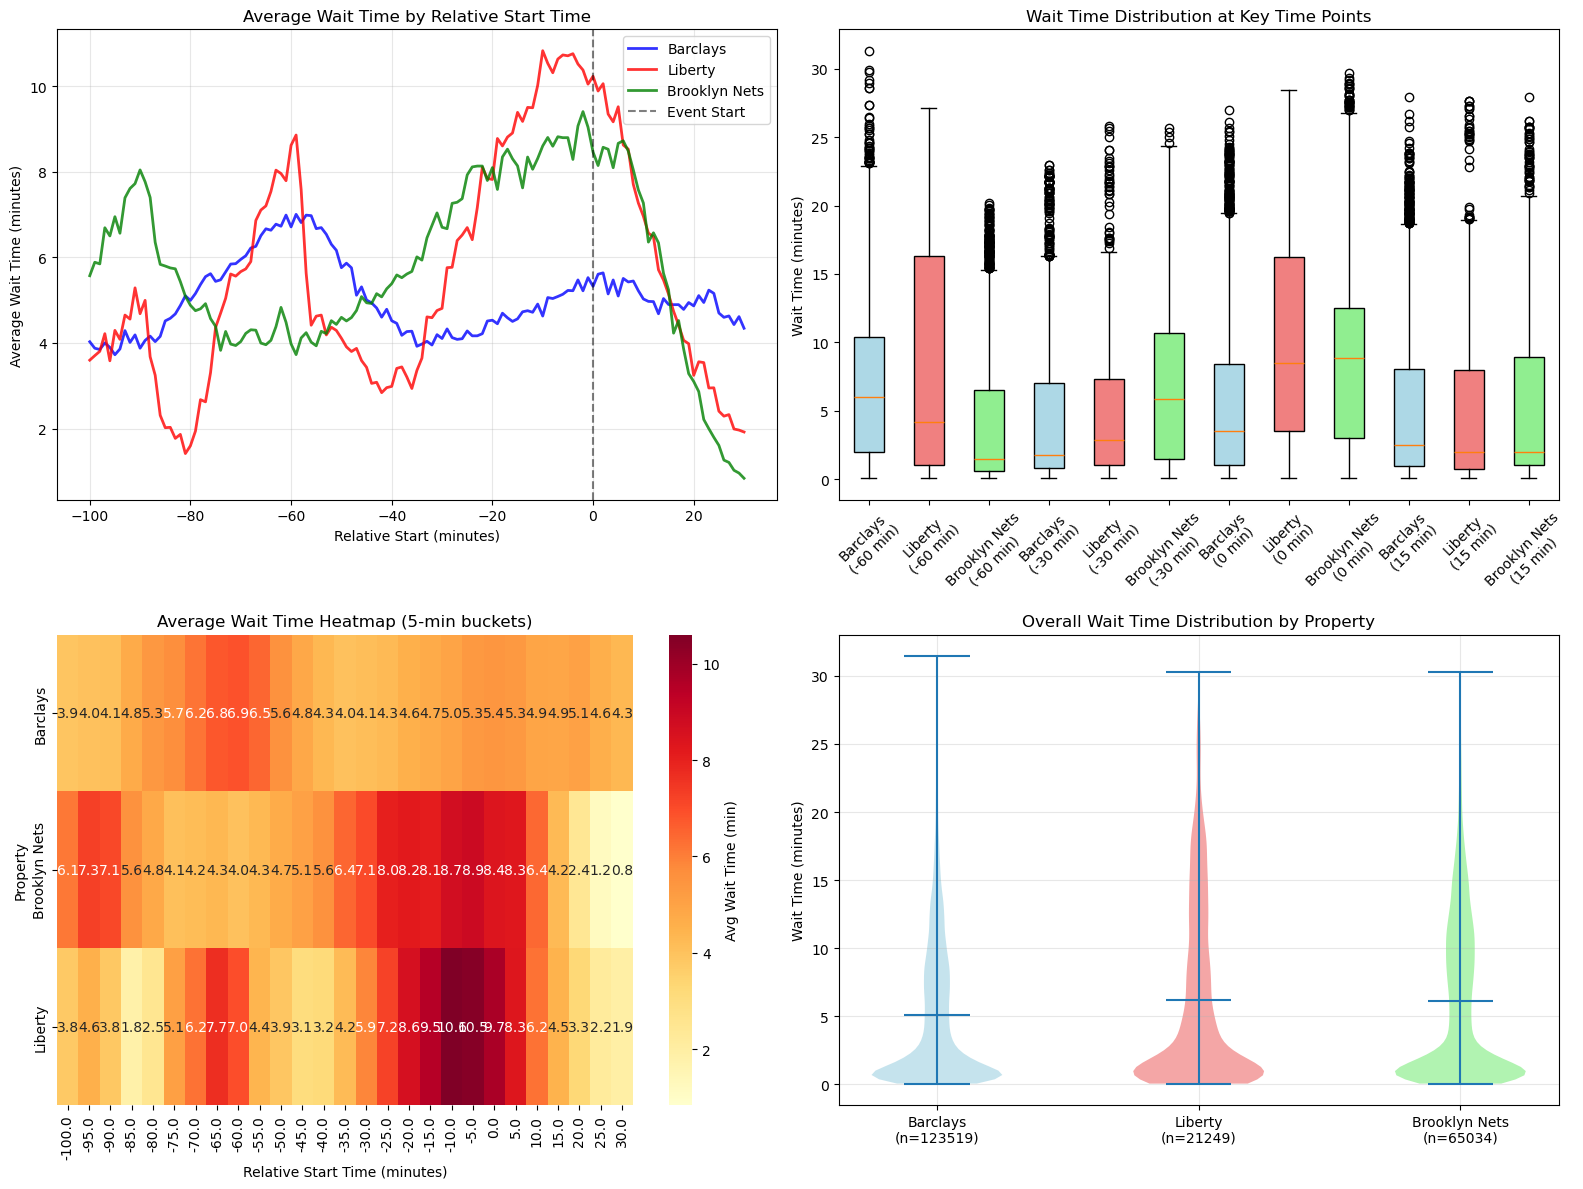

📊 SUMMARY STATISTICS BY PROPERTY

BARCLAYS:
  Total observations: 123,519
  Time range: -100 to 30 minutes
  Wait time - Mean: 5.1 min
  Wait time - Median: 3.0 min
  Wait time - 95th percentile: 15.4 min
  Wait time - Max: 31.5 min

LIBERTY:
  Total observations: 21,249
  Time range: -100 to 30 minutes
  Wait time - Mean: 6.2 min
  Wait time - Median: 3.2 min
  Wait time - 95th percentile: 19.3 min
  Wait time - Max: 30.3 min

BROOKLYN NETS:
  Total observations: 65,034
  Time range: -100 to 30 minutes
  Wait time - Mean: 6.1 min
  Wait time - Median: 3.6 min
  Wait time - 95th percentile: 17.3 min
  Wait time - Max: 30.3 min


In [56]:
# Create comprehensive visualization of wait time distributions
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Line plot showing average wait times over relative start time
ax1 = axes[0, 0]
for df_prop, label, color in [(df_barclays, 'Barclays', 'blue'), 
                              (df_liberty, 'Liberty', 'red'), 
                              (df_nets, 'Brooklyn Nets', 'green')]:
    if len(df_prop) > 0:
        avg_wait_by_minute = df_prop.groupby('relative start (minutes)')['wait time (minutes)'].mean()
        ax1.plot(avg_wait_by_minute.index, avg_wait_by_minute.values, 
                label=label, color=color, linewidth=2, alpha=0.8)

ax1.set_xlabel('Relative Start (minutes)')
ax1.set_ylabel('Average Wait Time (minutes)')
ax1.set_title('Average Wait Time by Relative Start Time')
ax1.axvline(0, color='black', linestyle='--', alpha=0.5, label='Event Start')
ax1.legend()
ax1.grid(True, alpha=0.3)

# 2. Box plot showing distribution at key time points
ax2 = axes[0, 1]
time_points = [-60, -30, 0, 15]
box_data = []
box_labels = []

for time_point in time_points:
    for df_prop, label in [(df_barclays, 'Barclays'), (df_liberty, 'Liberty'), (df_nets, 'Brooklyn Nets')]:
        if len(df_prop) > 0:
            # Get data within ±2 minutes of the time point
            subset = df_prop[abs(df_prop['relative start (minutes)'] - time_point) <= 2]
            if len(subset) > 0:
                box_data.append(subset['wait time (minutes)'])
                box_labels.append(f'{label}\n({time_point} min)')

if box_data:
    box_plot = ax2.boxplot(box_data, labels=box_labels, patch_artist=True)
    colors = ['lightblue', 'lightcoral', 'lightgreen'] * len(time_points)
    for patch, color in zip(box_plot['boxes'], colors):
        patch.set_facecolor(color)

ax2.set_ylabel('Wait Time (minutes)')
ax2.set_title('Wait Time Distribution at Key Time Points')
ax2.tick_params(axis='x', rotation=45)

# 3. Heatmap showing wait time intensity
ax3 = axes[1, 0]
# Create 5-minute buckets for better visualization
all_data = []
properties = []
property_dfs = [('Barclays', df_barclays), ('Liberty', df_liberty), ('Brooklyn Nets', df_nets)]

for prop_name, df_prop in property_dfs:
    if len(df_prop) > 0:
        # Create 5-minute buckets
        df_prop_copy = df_prop.copy()
        df_prop_copy['time_bucket'] = (df_prop_copy['relative start (minutes)'] // 5) * 5
        bucket_stats = df_prop_copy.groupby('time_bucket')['wait time (minutes)'].agg(['mean', 'count']).reset_index()
        bucket_stats = bucket_stats[bucket_stats['count'] >= 5]  # Only include buckets with sufficient data
        
        for _, row in bucket_stats.iterrows():
            all_data.append({
                'property': prop_name,
                'time_bucket': row['time_bucket'],
                'avg_wait_time': row['mean'],
                'count': row['count']
            })

if all_data:
    heatmap_df = pd.DataFrame(all_data)
    pivot_table = heatmap_df.pivot(index='property', columns='time_bucket', values='avg_wait_time')
    
    sns.heatmap(pivot_table, annot=True, fmt='.1f', cmap='YlOrRd', ax=ax3, cbar_kws={'label': 'Avg Wait Time (min)'})
    ax3.set_title('Average Wait Time Heatmap (5-min buckets)')
    ax3.set_xlabel('Relative Start Time (minutes)')
    ax3.set_ylabel('Property')

# 4. Violin plot showing full distributions
ax4 = axes[1, 1]
violin_data = []
violin_labels = []

for df_prop, label, color in [(df_barclays, 'Barclays', 'blue'), 
                              (df_liberty, 'Liberty', 'red'), 
                              (df_nets, 'Brooklyn Nets', 'green')]:
    if len(df_prop) > 0:
        violin_data.append(df_prop['wait time (minutes)'])
        violin_labels.append(f'{label}\n(n={len(df_prop)})')

if violin_data:
    violin_parts = ax4.violinplot(violin_data, positions=range(len(violin_data)), showmeans=True)
    
    # Color the violins
    colors = ['lightblue', 'lightcoral', 'lightgreen']
    for i, (pc, color) in enumerate(zip(violin_parts['bodies'], colors)):
        pc.set_facecolor(color)
        pc.set_alpha(0.7)

ax4.set_xticks(range(len(violin_labels)))
ax4.set_xticklabels(violin_labels)
ax4.set_ylabel('Wait Time (minutes)')
ax4.set_title('Overall Wait Time Distribution by Property')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary statistics
print("📊 SUMMARY STATISTICS BY PROPERTY")
print("=" * 50)

for df_prop, label in [(df_barclays, 'Barclays'), (df_liberty, 'Liberty'), (df_nets, 'Brooklyn Nets')]:
    if len(df_prop) > 0:
        print(f"\n{label.upper()}:")
        print(f"  Total observations: {len(df_prop):,}")
        print(f"  Time range: {df_prop['relative start (minutes)'].min():.0f} to {df_prop['relative start (minutes)'].max():.0f} minutes")
        print(f"  Wait time - Mean: {df_prop['wait time (minutes)'].mean():.1f} min")
        print(f"  Wait time - Median: {df_prop['wait time (minutes)'].median():.1f} min")
        print(f"  Wait time - 95th percentile: {df_prop['wait time (minutes)'].quantile(0.95):.1f} min")
        print(f"  Wait time - Max: {df_prop['wait time (minutes)'].max():.1f} min")

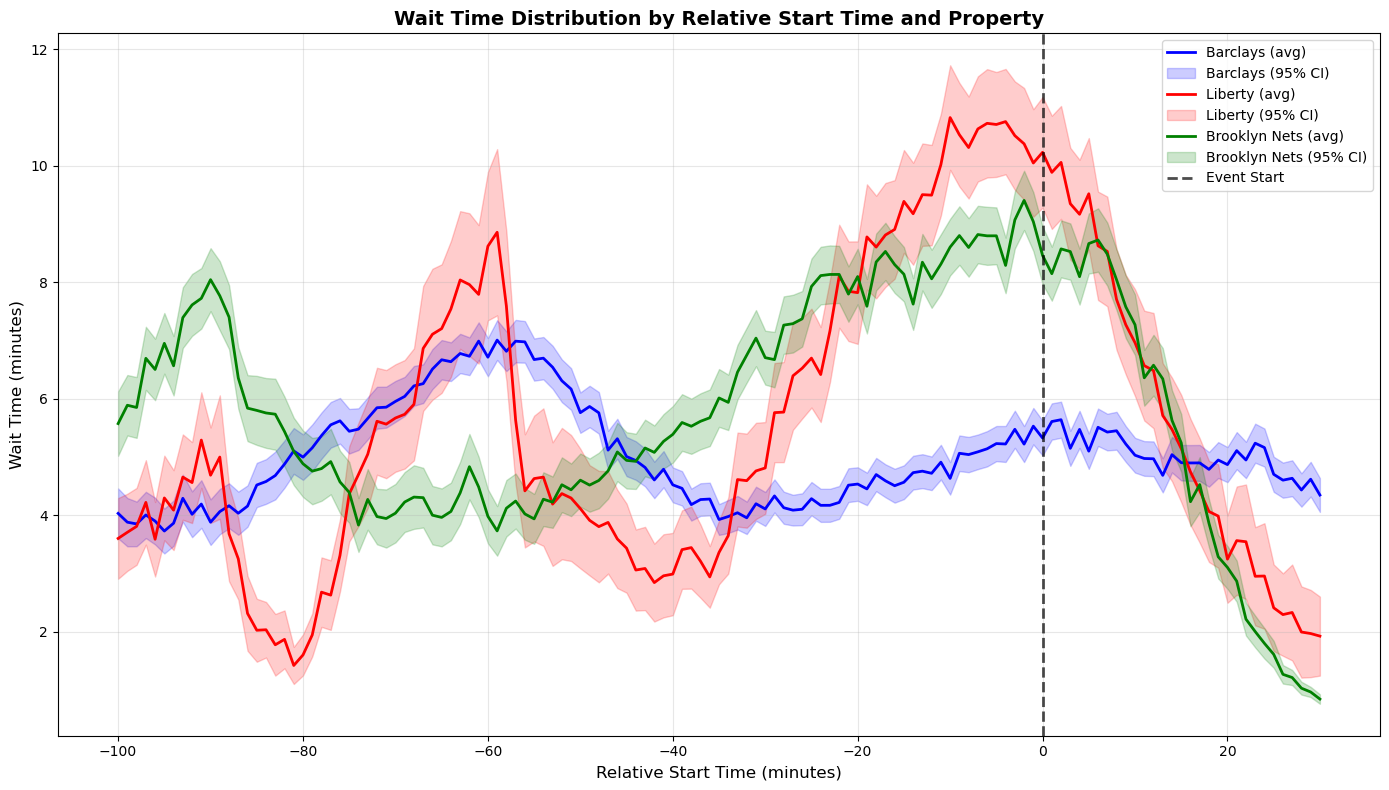


🎯 PEAK WAIT TIME ANALYSIS

Barclays:
  Peak wait time: 7.0 minutes
  Occurs at: -59 minutes relative to event start
  Pre-event avg: 5.1 minutes
  Post-event avg: 5.0 minutes

Liberty:
  Peak wait time: 10.8 minutes
  Occurs at: -10 minutes relative to event start
  Pre-event avg: 6.3 minutes
  Post-event avg: 6.1 minutes

Brooklyn Nets:
  Peak wait time: 9.4 minutes
  Occurs at: -2 minutes relative to event start
  Pre-event avg: 6.3 minutes
  Post-event avg: 5.5 minutes


In [57]:
# Alternative: Simple line plot with confidence intervals
plt.figure(figsize=(14, 8))

# Calculate mean and confidence intervals for each property
colors = {'Barclays': 'blue', 'Liberty': 'red', 'Brooklyn Nets': 'green'}

for df_prop, label in [(df_barclays, 'Barclays'), (df_liberty, 'Liberty'), (df_nets, 'Brooklyn Nets')]:
    if len(df_prop) > 0:
        # Group by relative start time and calculate statistics
        stats_by_minute = df_prop.groupby('relative start (minutes)')['wait time (minutes)'].agg([
            'mean', 'std', 'count'
        ]).reset_index()
        
        # Filter out minutes with very few observations
        stats_by_minute = stats_by_minute[stats_by_minute['count'] >= 3]
        
        if len(stats_by_minute) > 0:
            x = stats_by_minute['relative start (minutes)']
            y = stats_by_minute['mean']
            
            # Calculate confidence interval (using standard error)
            se = stats_by_minute['std'] / np.sqrt(stats_by_minute['count'])
            ci_lower = y - 1.96 * se
            ci_upper = y + 1.96 * se
            
            # Plot line and confidence interval
            color = colors[label]
            plt.plot(x, y, label=f'{label} (avg)', color=color, linewidth=2)
            plt.fill_between(x, ci_lower, ci_upper, color=color, alpha=0.2, label=f'{label} (95% CI)')

plt.axvline(0, color='black', linestyle='--', alpha=0.7, linewidth=2, label='Event Start')
plt.xlabel('Relative Start Time (minutes)', fontsize=12)
plt.ylabel('Wait Time (minutes)', fontsize=12)
plt.title('Wait Time Distribution by Relative Start Time and Property', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Show peak wait times for each property
print("\n🎯 PEAK WAIT TIME ANALYSIS")
print("=" * 40)

for df_prop, label in [(df_barclays, 'Barclays'), (df_liberty, 'Liberty'), (df_nets, 'Brooklyn Nets')]:
    if len(df_prop) > 0:
        # Find the time with highest average wait time
        avg_by_minute = df_prop.groupby('relative start (minutes)')['wait time (minutes)'].mean()
        peak_time = avg_by_minute.idxmax()
        peak_wait = avg_by_minute.max()
        
        print(f"\n{label}:")
        print(f"  Peak wait time: {peak_wait:.1f} minutes")
        print(f"  Occurs at: {peak_time:.0f} minutes relative to event start")
        
        # Show pre-event vs post-event averages
        pre_event = df_prop[df_prop['relative start (minutes)'] < 0]['wait time (minutes)'].mean()
        post_event = df_prop[df_prop['relative start (minutes)'] >= 0]['wait time (minutes)'].mean()
        
        print(f"  Pre-event avg: {pre_event:.1f} minutes")
        print(f"  Post-event avg: {post_event:.1f} minutes")

In [58]:
print("Barclays unique values per column:")
for col in df_barclays.columns:
    print(f"{col}: {df_barclays[col].nunique()}")

Barclays unique values per column:
event_name: 195
event_name_long: 148
season_name: 122
season_year: 3
event_date: 163
event_time: 22
event_day: 7
starttime: 186
team: 130
event_type: 1
minor_category: 28
numberinline: 395
relative start (minutes): 131
wait time (minutes): 678
time category: 6


In [59]:
print("Liberty unique values per column:")
for col in df_liberty.columns:
    print(f"{col}: {df_liberty[col].nunique()}")

Liberty unique values per column:
event_name: 38
event_name_long: 22
season_name: 3
season_year: 3
event_date: 38
event_time: 6
event_day: 7
starttime: 39
team: 12
event_type: 1
minor_category: 1
numberinline: 403
relative start (minutes): 131
wait time (minutes): 605
time category: 6


In [60]:
print("Nets unique values per column:")
for col in df_nets.columns:
    print(f"{col}: {df_nets[col].nunique()}")

Nets unique values per column:
event_name: 80
event_name_long: 61
season_name: 2
season_year: 2
event_date: 80
event_time: 8
event_day: 7
starttime: 79
team: 30
event_type: 1
minor_category: 1
numberinline: 418
relative start (minutes): 131
wait time (minutes): 614
time category: 6
